In [1]:
import numpy as np
import pandas as pd
import pegasus as pg
import json
import os
import pegasusio
from pegasusio import UnimodalData, MultimodalData
import matplotlib.pyplot as plt 
import scipy.sparse
import matplotlib.patches as mpatches
import itertools
from matplotlib import cm
import random
import scipy.io as sio
import matplotlib.cm
import glob
from matplotlib import font_manager
from utils.lists import *
from matplotlib_venn import venn2, venn2_circles

/gpfs/gibbs/pi/gerstein/ah2428/conda_envs/r2r/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ED Fig. 7b Peak jaccard similarity

In [3]:
jaccard = pd.read_csv('/gpfs/gibbs/pi/girgenti/JZhang/commonData/PTSD/ATAC/scripts/jaccard_outs.txt',header=None)
jac = jaccard[0].values.reshape((7,7))

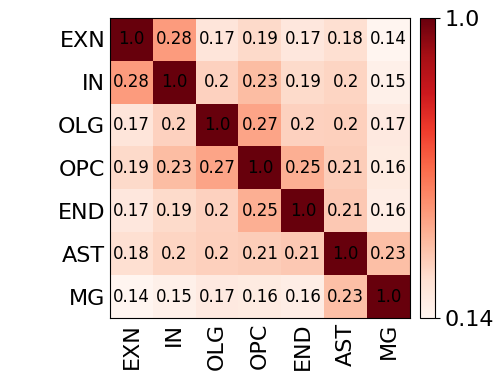

In [4]:
# jaccard similarity: intersection/union
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig = plt.figure(figsize=(5,5))

ax1 = fig.add_axes([0.1,0.1,0.8,0.6])

plt.rcParams['font.size']= '16'

ax1.axis('off')
ax1.set_xticks([])
ax1.set_yticks([])

axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
im = axmatrix.matshow(np.log(jac), aspect='auto', cmap='Reds')
axmatrix.set(xticks=np.arange(len(celltypes)),xticklabels=celltypes)
axmatrix.set_xticklabels(celltypes,rotation=90)
axmatrix.tick_params(axis="x", labelbottom=True, labeltop=False)
axmatrix.set(yticks=np.arange(len(celltypes)),yticklabels=celltypes)
axmatrix.tick_params(axis=u'both', which=u'both',length=0)


axcolor = fig.add_axes([0.92,0.1,0.03,0.6])
cbar = plt.colorbar(im, cax=axcolor)
cbar.set_ticks([np.log(jac).min(),np.log(jac).max()])
cbar.set_ticklabels([np.round(jac.min(),2),jac.max()])

for i in range(7):
    for j in range(7):
        axmatrix.text(i,j,np.round(jac[i,j],2),ha="center", va="center",fontsize=12)

# ED Fig. 7c ATAC peaks vs bulk peaks

In [5]:
peaks = '/gpfs/gibbs/pi/girgenti/JZhang/commonData/PTSD/ATAC/bulk_overlap'

In [6]:
folder = '/gpfs/gibbs/pi/girgenti/JZhang/commonData/PTSD/ATAC/bulk_overlap/out'

In [7]:
ts = [0.2, 0.4, 0.6, 0.8, 1.0] 
allratios = []

all_dfs = []
for celltype in ['Exc','Inh','Oli','Opc','End','Ast','Mic']:
    p = f'/gpfs/gibbs/pi/girgenti/JZhang/commonData/PTSD/ATAC/bulk_overlap/{celltype}.peaks.bed'
    celltype = p.split('/')[10].split('.')[0]
    n = sum([1 for i in open(p,"r").readlines() if i.strip()])
    ratios = []
    for t in ts:
        f = f'/gpfs/gibbs/pi/girgenti/JZhang/commonData/PTSD/ATAC/bulk_overlap/out/{celltype}.{t}.peaks.bed'
        t_n = sum([1 for i in open(f,"r").readlines() if i.strip()])
        
        ratio = t_n/n
        ratios.append(ratio)
    df = pd.DataFrame({'ratio':ts,'celltype':celltype,'value':ratios})
    allratios.append(ratios)
    all_dfs.append(df)

In [8]:
all_dfs = pd.concat(all_dfs)

In [9]:
colors = list(celltype_colors2.values())
colors_new = list(itertools.chain(*[[x]*5 for x in colors]))

Text(0, 0.5, 'Overlap %')

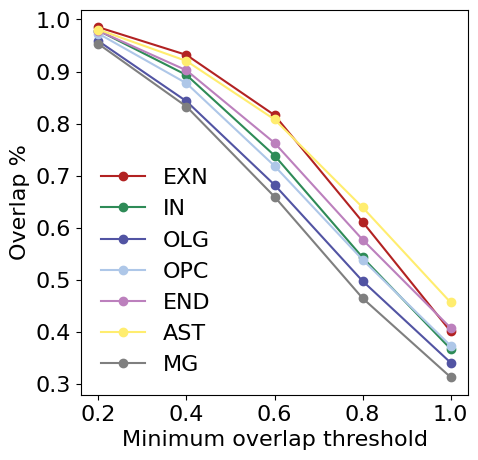

In [11]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']= '16'
fig, ax = plt.subplots(figsize=(5,5))

for ratios,cell,color in zip(allratios,celltypes,colors):
    ax.plot(ts,ratios,'-o',label=cell,color=color)
ax.set(xticks=ts,xticklabels=ts)
plt.legend(frameon=False)

plt.xlabel('Minimum overlap threshold')
plt.ylabel('Overlap %')

# ED Fig. 7d CLG-DEG

In [12]:
p2g = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/ATAC/data/p2glinks_maxDist_2M.csv',sep='\t')
cre = p2g[p2g.Correlation > 0.4][p2g.FDR < 0.05]

/tmp/ipykernel_537084/1311357388.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cre = p2g[p2g.Correlation > 0.4][p2g.FDR < 0.05]


In [13]:
cre_meta = pd.read_csv('/home/ah2428/palmer_scratch/supp_tables/CRE_metadata.csv',sep='\t')

In [14]:
cre_meta['chr'] = [x.split(':')[0] for x in cre_meta['CRE'].values]
cre_meta['start'] = [x.split(':')[1].split('-')[0] for x in cre_meta['CRE'].values]
cre_meta['end'] = [x.split(':')[1].split('-')[1] for x in cre_meta['CRE'].values]
cre_meta['peakName'] = cre_meta['chr']+'_'+cre_meta['start']+'_'+cre_meta['end']

In [15]:
deg = pd.read_csv('/home/ah2428/palmer_scratch/supp_tables/txt/PTSD_DEG_MAST_and_Wilcox.txt',sep='\t')

In [16]:
inter_genes = []
for ii,cell in zip(np.arange(len(celltypes)),['EXN','IN','OLG','OPC','END','AST','MG']):
    cell_cres = cre_meta[cre_meta.Celltype==cell].peakName.values
    cell_p2g = cre[cre.peakName.isin(cell_cres)]
    clgs = cell_p2g.geneName.unique()
    degs = deg[deg['Celltype']==cell].Genename.values
    inter = list(set(clgs)&set(degs))
    inter_genes.append(inter)

In [17]:
arr = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        n = len(list(set(inter_genes[i]) & set(inter_genes[j])))
        arr[i,j] = n

/tmp/ipykernel_537084/3156893959.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(arr),cmap='Reds')
/tmp/ipykernel_537084/3156893959.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(' ')


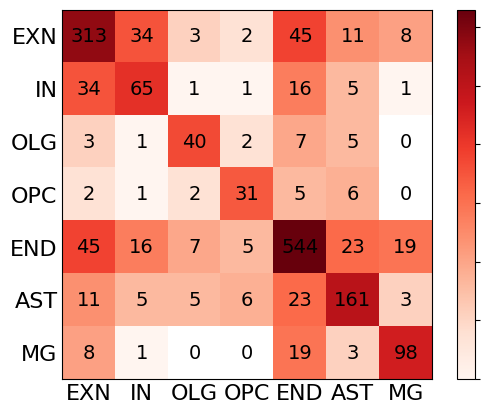

In [19]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.imshow(np.log(arr),cmap='Reds')
for i in range(7):
    for j in range(7):
        plt.text(i,j,int(arr[i,j]),ha="center", va="center",fontsize=14)
        
plt.xticks(np.arange(7),['EXN','IN','OLG','OPC','END','AST','MG'],fontsize=16)
plt.yticks(np.arange(7),['EXN','IN','OLG','OPC','END','AST','MG'],fontsize=16)

plt.tick_params(axis=u'both', which=u'both',length=0)
cbar = plt.colorbar()
cbar.set_ticklabels(' ')